# Hackathon – Jour 2 : Exploration de données

Ce notebook présente l'analyse exploratoire des données bruit et trafic aérien pour la région Île-de-France.

In [8]:

import pandas as pd
import matplotlib.pyplot as plt
import folium

# Affichage plus lisible
pd.set_option("display.max_columns", None)


## 1. Chargement des données

In [10]:

bruit = pd.read_csv("../Data/bruit_survol.csv")
opensky = pd.read_csv("../Data/opensky_snapshot.csv")
flights = pd.read_csv("../Data/flights_history.csv")

print("Bruit:", bruit.shape)
print("OpenSky:", opensky.shape)
print("Flights:", flights.shape)


Bruit: (146, 8)
OpenSky: (100, 11)
Flights: (150, 9)


## 2. Nettoyage des données

In [11]:

# Conversion des dates
bruit["timestamp_iso"] = pd.to_datetime(bruit["timestamp_iso"])
opensky["time_position_unix"] = pd.to_datetime(opensky["time_position_unix"], unit="s")
flights["first_seen_iso"] = pd.to_datetime(flights["first_seen_iso"])
flights["last_seen_iso"] = pd.to_datetime(flights["last_seen_iso"])

# Suppression doublons
bruit = bruit.drop_duplicates()
opensky = opensky.drop_duplicates()
flights = flights.drop_duplicates()

# Aperçu
bruit.head()


,station_id,station_name,timestamp_iso,LAeq_dB,Lmax_dB,latitude,longitude,airport
0,SURV006,Le Bourget - Station 2,2025-09-22 08:12:00,58.0,63.6,48.925908,2.476151,CDG
1,SURV006,Le Bourget - Station 2,2025-09-22 02:37:00,53.6,58.9,48.963169,2.438372,ORY
2,SURV002,Aéroport Charles de Gaulle - Sud,2025-09-22 07:15:00,52.2,59.8,48.881463,2.376714,CDG
3,SURV006,Le Bourget - Station 2,2025-09-21 17:24:00,56.5,56.8,48.831003,2.371886,CDG
4,SURV005,Le Bourget - Station 1,2025-09-21 21:36:00,53.9,60.8,48.863679,2.329385,CDG


## 3. Analyse exploratoire des données

In [13]:
print("Statistiques bruit:")
cols_bruit = [col for col in bruit.columns if bruit[col].dtype in ['float64', 'int64']]
if cols_bruit:
    print(bruit[cols_bruit].describe())
else:
    print("Aucune colonne numérique trouvée dans bruit.")

print("\nStatistiques vols:")
cols_opensky = [col for col in opensky.columns if opensky[col].dtype in ['float64', 'int64']]
if cols_opensky:
    print(opensky[cols_opensky].describe())
else:
    print("Aucune colonne numérique trouvée dans opensky.")


Statistiques bruit:
          LAeq_dB     Lmax_dB    latitude   longitude
count  146.000000  146.000000  146.000000  146.000000
mean    55.701370   61.773973   48.894695    2.403992
std      4.070736    5.210322    0.038643    0.052755
min     46.100000   49.900000   48.795210    2.300622
25%     52.600000   58.000000   48.863759    2.360000
50%     55.750000   61.500000   48.899500    2.409537
75%     58.400000   65.650000   48.918198    2.442955
max     67.000000   74.400000   48.976000    2.538000

Statistiques vols:
        longitude    latitude  baro_altitude_m  velocity_m_s  heading_deg  \
count  100.000000  100.000000       100.000000    100.000000   100.000000   
mean     2.363117   48.870806      8888.950000    211.025000   195.047000   
std      0.085019    0.062658      4275.743284     59.932232   110.530148   
min      2.187034   48.764192         0.000000     88.000000    18.600000   
25%      2.315384   48.822182      6133.500000    173.425000   101.725000   
50%      2.3

## 4. Visualisations

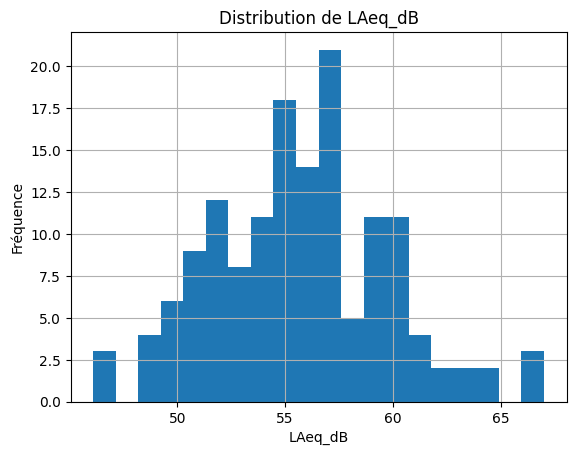

In [14]:
# Histogramme du bruit (première colonne numérique disponible)
num_cols_bruit = [col for col in bruit.columns if bruit[col].dtype in ['float64', 'int64']]
if num_cols_bruit:
    bruit[num_cols_bruit[0]].hist(bins=20)
    plt.xlabel(num_cols_bruit[0])
    plt.ylabel("Fréquence")
    plt.title(f"Distribution de {num_cols_bruit[0]}")
    plt.show()
else:
    print("Aucune colonne numérique trouvée dans bruit pour l'histogramme.")

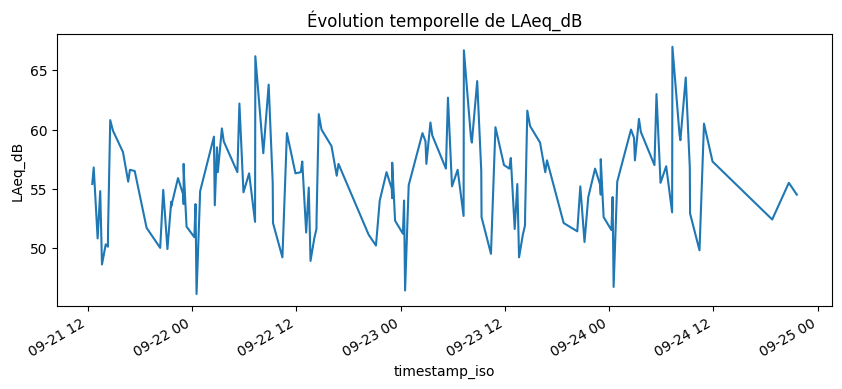

In [15]:
# Série temporelle bruit (triée par date pour une courbe correcte)
if "timestamp_iso" in bruit.columns and num_cols_bruit:
    bruit["timestamp_iso"] = pd.to_datetime(bruit["timestamp_iso"], errors="coerce")
    df_plot = bruit.dropna(subset=["timestamp_iso", num_cols_bruit[0]]).sort_values("timestamp_iso")
    if not df_plot.empty:
        df_plot.set_index("timestamp_iso")[num_cols_bruit[0]].plot(figsize=(10,4))
        plt.ylabel(num_cols_bruit[0])
        plt.title(f"Évolution temporelle de {num_cols_bruit[0]}")
        plt.show()
    else:
        print("Aucune donnée valide pour la série temporelle.")
else:
    print("Impossible d'afficher la série temporelle : colonne timestamp_iso ou numérique manquante.")

In [17]:
# Carte interactive des mesures de bruit

import folium  # Assure que folium est bien importé

lat_col = next((col for col in bruit.columns if 'lat' in col.lower()), None)
lon_col = next((col for col in bruit.columns if 'lon' in col.lower()), None)
val_col = num_cols_bruit[0] if num_cols_bruit else None

if lat_col and lon_col and val_col:
    # Centre de la carte : moyenne des coordonnées
    m = folium.Map(location=[bruit[lat_col].mean(), bruit[lon_col].mean()], zoom_start=10)
    for _, row in bruit.dropna(subset=[lat_col, lon_col, val_col]).iterrows():
        folium.CircleMarker(
            location=[row[lat_col], row[lon_col]],
            radius=5,
            color='blue',
            fill=True,
            fill_color='red',
            fill_opacity=0.6,
            popup=f"{val_col}: {row[val_col]:.2f}"
        ).add_to(m)
    try:
        from IPython.display import display
        display(m)
    except ImportError:
        m
else:
    print("Colonnes latitude/longitude ou valeur de bruit manquantes pour la carte.")

## 5. Analyses complémentaires

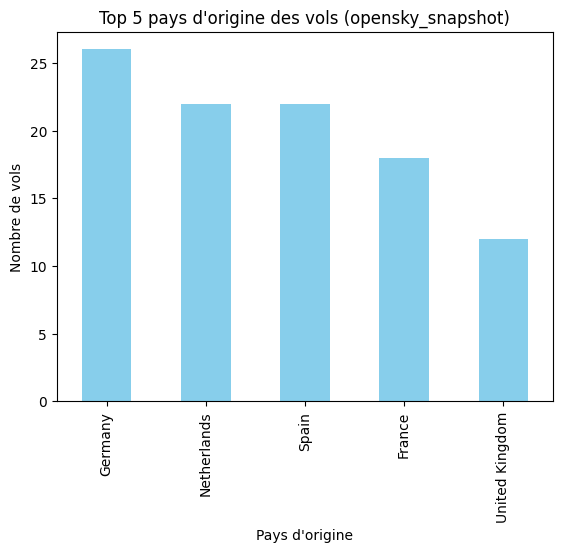

In [19]:
# Top 5 origines et destinations dans opensky_snapshot

# Origines
if "origin_country" in opensky.columns:
    top_origins = opensky["origin_country"].value_counts().head(5)
    top_origins.plot(kind="bar", color="skyblue")
    plt.title("Top 5 pays d'origine des vols (opensky_snapshot)")
    plt.ylabel("Nombre de vols")
    plt.xlabel("Pays d'origine")
    plt.show()
else:
    print("Colonne 'origin_country' non trouvée dans opensky_snapshot.")